In [13]:
#### ---- Self-adaptive weighted filter to remove GAUSSIAN & IMPULSIVE noise in INFRARED images ---- ####

## for color images

In [14]:
import numpy as np
import cv2
from scipy import signal
from skimage import io, color
from matplotlib import pyplot as plt
import math

window_size = 3
W = window_size//2
poz_median=window_size*window_size//2

T1 = 80 # for differences values between pixels
T2 = 3 # for number of pixels in window

In [15]:
# MSE

def MSE(imgref, imgzg):
    # problema cu int si float
    # diferenta poata fi negativa (se da peste cap) -> normalizam
    if (np.max(imgref) > 1):
      imgref = imgref/255.0
    if (np.max(imgzg) > 1):
      imgzg = imgzg/255.0

    MSE = np.sum((imgzg - imgref)**2)/np.prod(np.shape(imgref))
    
    # MSE normalizat
    sumval = np.sum(imgref**2)
    NMSE = MSE/sumval

    return MSE, NMSE

#####################################################

def add_gaussian_noise(img, disp):
   # standardizam la gama de valori
   if (np.max(img) > 1):
      img = img/255.0
      
   zg = np.random.normal(0,disp,np.shape(img))
   img_zg = img + zg
   # e posibil ca unele valori sa iasa din gama [0,1]
   img_zg = np.clip(img_zg, a_min = 0, a_max =1)

   return img_zg


## sare si piper
def add_impulsive_noise(img, procent_negru, procent_alb):
   
   # standardizam la gama de valori
   if (np.max(img) > 1):
      img = img/255.0

   [L,C, pl] = np.shape(img)
   nr_pixeli_zero = int(L*C*procent_negru)
   nr_pixeli_unu = int(L*C*procent_alb)

   for plan_curent in range(pl):
    numere_intregi_L = np.random.randint(0,L, nr_pixeli_zero)
    numere_intregi_C = np.random.randint(0,C, nr_pixeli_zero)
    img[numere_intregi_L, numere_intregi_C, plan_curent] = 0

    numere_intregi_L = np.random.randint(0,L, nr_pixeli_unu)
    numere_intregi_C = np.random.randint(0,C, nr_pixeli_unu)
    img[numere_intregi_L, numere_intregi_C, plan_curent] = 1

   return img

#####################################################

def bordare_imagine(img, nucleu):
    # TODO delete nucleu from function

    [L,C,pl] = np.shape(img)
    if np.max(img) > 1:
        img = img/255.
    nucleu = nucleu/np.sum(nucleu)
    [d1, d2] = np.shape(nucleu)

    kernel = np.zeros((d1+1, d2+1))
    kernel[d1//2,d2//2] = 1

    Ybordered = np.zeros((L+d1,C+d2,pl))
    for pl in range(0,3):
        Ybordered[:,:,pl] = signal.convolve2d(img[:,:,pl], kernel, mode='full', boundary='symm')

    return Ybordered


def compute_thresholds(image):
    """
    Compute thresholds based on image details.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        tuple: A tuple containing two thresholds (threshold1, threshold2).
    """
    if image is None:
        raise ValueError("Image not found or invalid image format.")

    # Calculate edge density using Canny edge detection
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size

    # Calculate variance of pixel intensity
    intensity_variance = np.var(image)

    # Normalize metrics to a range of 0 to 1
    normalized_edge_density = min(1, edge_density / 0.1)  # Assume 0.1 is high edge density
    normalized_intensity_variance = min(1, intensity_variance / 5000)  # Adjust 5000 based on experimentation

    # Combine metrics to estimate image details (weights can be adjusted)
    detail_level = 0.7 * normalized_edge_density + 0.3 * normalized_intensity_variance

    # Scale thresholds based on detail level
    threshold1 = 40 + detail_level * (90 - 40)
    threshold2 = 1 + detail_level * (8 - 1)

    return round(threshold1), round(threshold2)

In [16]:
def calculate_weights(flattened_window, diff):
    """Calculate adaptive weights for a filter window."""

    differences = np.abs(flattened_window - diff)
    weights = 1/(1+differences**2)
    normalized_weights = weights/np.sum(weights)

    return normalized_weights

flattened_window = np.array([8, 2, 10, 4, 6, 9])
diff = 7

print(calculate_weights(flattened_window, diff))


[0.34759358 0.02673797 0.06951872 0.06951872 0.34759358 0.13903743]


In [17]:
def gaussian_filter(img, nucleu):
    
    # mean -> nucleu = np.ones((9,9))/81.0
    if np.max(img) > 1:
        img = img/255.
    nucleu = nucleu/np.sum(nucleu)
    [d1, d2] = np.shape(nucleu)

    kernel = np.zeros((d1+1, d2+1))
    kernel[d1//2,d2//2] = 1
    [L,C,pl] = np.shape(img)
    imgout = np.zeros((L,C,pl))
    for pl in range(0,3):

        Ybordered = signal.convolve2d(img[:,:,pl], kernel, mode='full', boundary='symm')
        for l in range(0,L):
            for c in range(0,C):
                imgout[l,c,pl] = np.sum(nucleu*Ybordered[l:l+d1, c:c+d2])

    return imgout

#####################################################

def median_filter(img, nucleu):
    """Apply the median filter."""
    # nucleu 3x3
    if np.max(img) > 1:
        img = img/255.
    nucleu = nucleu/np.sum(nucleu)
    [d1, d2] = np.shape(nucleu)

    kernel = np.zeros((d1+1, d2+1))
    kernel[d1//2,d2//2] = 1
    [L,C,pl] = np.shape(img)
    imgout = np.zeros((L,C,pl))
    for pl in range(0,3):

        Ybordered = signal.convolve2d(img[:,:,pl], kernel, mode='full', boundary='symm')
        for l in range(0,L):
            for c in range(0,C):
                val_selectate = Ybordered[l:l+d1, c:c+d2]
                val_sortate = np.sort(val_selectate.flatten())
                mijloc = val_sortate[d1*d2//2]
                imgout[l,c,pl] = mijloc

    return imgout



In [18]:
### Window filter functions for grayscale images ###

def gaussian_filter_in_window_gray(window):
    # 3x3 window
    mean = np.mean(window)
    weights = calculate_weights(window, mean)

    centered_pixel = np.sum(weights*window[:,:])  

    return centered_pixel  

#####################################################

def impulsive_filter_in_window_gray(window):
    # 3x3 window
    val_sortate = np.sort(window)
    val_sortate = val_sortate[1:len(val_sortate)-1]

    middle_val = val_sortate[len(val_sortate)//2]
    weights = calculate_weights(val_sortate, middle_val)
    
    centered_pixel = np.sum(weights*window[1:len(window)-1]) 

    return centered_pixel

In [19]:
### Window filter functions for color images ###

def gaussian_filter_in_window_color(window):
    # 3x3x3 window
    centered_pixel = np.zeros((3))
    
    for plan in range(0,3):
        mean = np.mean(window[:,:,plan])
        weights = calculate_weights(window[:,:,plan], mean)

        centered_pixel[plan] = np.sum(weights*window[:,:,plan])  

    return np.round(centered_pixel,0)  

#####################################################

def impulsive_filter_in_window_color(window):
    # 3x3x3 window
    centered_pixel = np.zeros((3))

    for plan in range(0,3):
        val_selectate = np.sort(window[:,:,plan])
        val_sortate = val_selectate[1:len(val_selectate)-1].flatten()
        middle_val = val_sortate[len(val_sortate)//2]
        weights = calculate_weights(val_sortate, middle_val)

        centered_pixel[plan] = np.sum(weights*window[:,:,plan])  

    return np.round(centered_pixel,)

original image has also transparency 
size was (542, 850, 4)


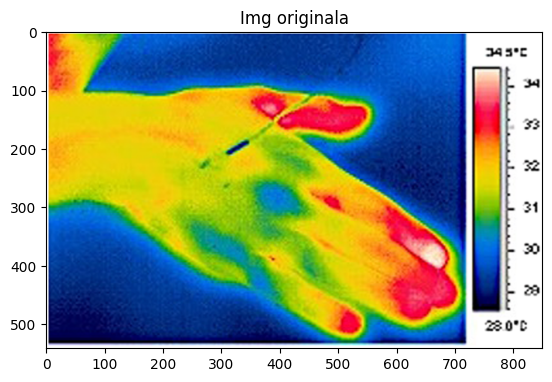

[[[195 213   8]
  [200 216  12]
  [204 217  13]]

 [[194 212   6]
  [198 213   9]
  [200 213   9]]

 [[193 211   5]
  [196 211   6]
  [197 210   5]]]
Centrul gaussian in fereastra: [197. 213.   8.]
Centrul impulsiv in fereastra: [595. 639.  27.]


In [20]:
## Testing the window functions for filter color images ##

img = io.imread('Thermogram-infrared-image-Image-of-a-hand-taken-in-mid-infrared-thermal-light (1).png')
L,C,pl = np.shape(img)

if pl > 3:
    print("original image has also transparency \nsize was {0}".format(np.shape(img)))
    img=img[:,:,:3]
else:
    print(np.shape(img))

img=np.uint8(img)
plt.figure(), plt.title("Img originala"), plt.imshow(img), plt.show()

window = img[245:248,245:248,0:3]
print(window)

gaussian_pixel = gaussian_filter_in_window_color(window)
impulsive_pixel = impulsive_filter_in_window_color(window)

print("Centrul gaussian in fereastra: {0}".format(gaussian_pixel))
print("Centrul impulsiv in fereastra: {0}".format(impulsive_pixel))

original image has also transparency 
size was (542, 850, 4)


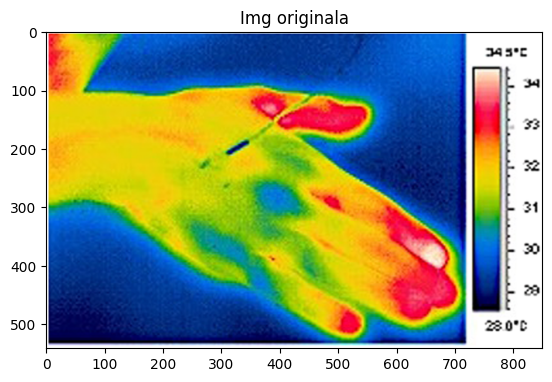

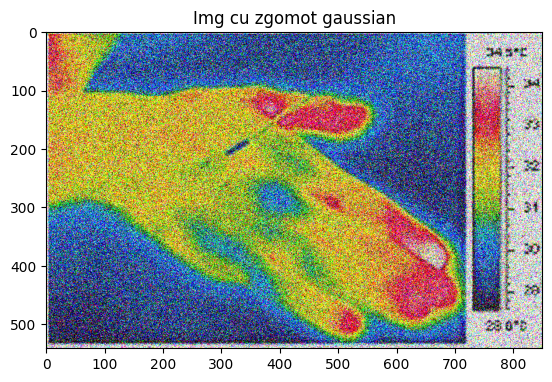

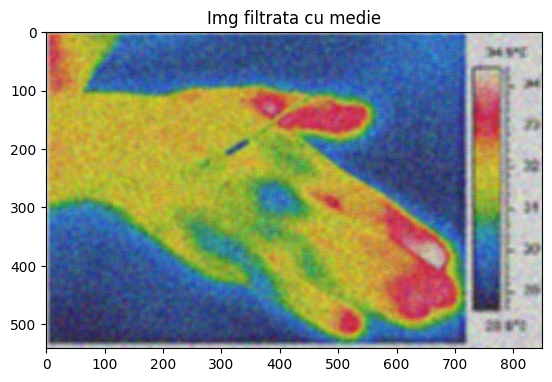

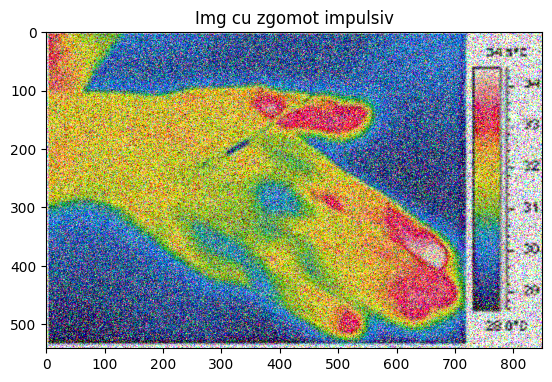

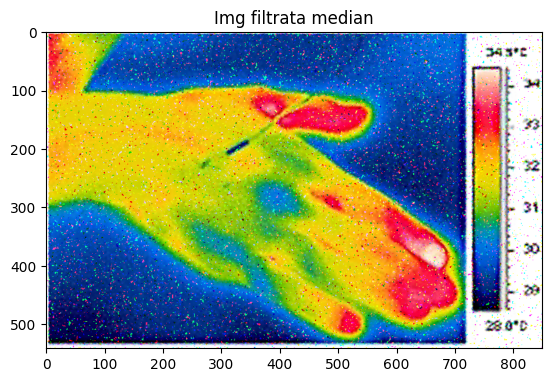

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Img filtrata median'),
 None)

In [21]:
# Example usage of normal mean and median filter
#                 gaussian       impulsive noise
img = io.imread('Thermogram-infrared-image-Image-of-a-hand-taken-in-mid-infrared-thermal-light (1).png')
L,C,pl = np.shape(img)

if pl > 3:
    print("original image has also transparency \nsize was {0}".format(np.shape(img)))
    img=img[:,:,:3]
else:
    print(np.shape(img))

img=np.uint8(img)
plt.figure(), plt.title("Img originala"), plt.imshow(img), plt.show()

# add gaussian noise
img_noise_gauss = add_gaussian_noise(img, 0.5)
plt.figure(), plt.title("Img cu zgomot gaussian"), plt.imshow(img_noise_gauss), plt.show()

# # Apply the self-adaptive weighted gaussian filter
filtered_image_gauss = gaussian_filter(img_noise_gauss, np.ones((9,9))/81.0)
plt.figure(),plt.title("Img filtrata cu medie") , plt.imshow(filtered_image_gauss), plt.show()

# ###########################

# # add impulsive noise
img_noise_impulsive = add_impulsive_noise(img, 0.25, 0.25)
plt.figure(),plt.title("Img cu zgomot impulsiv") , plt.imshow(img_noise_impulsive), plt.show()

# # Apply the self-adaptive weighted impulsive filter
filtered_image_impulsive = median_filter(img_noise_impulsive, np.ones((3,3))/9.0)
plt.figure(),plt.title("Img filtrata median") , plt.imshow(filtered_image_impulsive), plt.show()


In [22]:
def compute_image_with_noise_color(img_noise_color, nucleu, T1, T2):
    gaussian_counter = 0
    impulsive_counter = 0
    normal_counter = 0

    [L,C,pl]=np.shape(img_noise_color)
    Ybordat = bordare_imagine(img_noise_color, nucleu) 
    print(np.shape(Ybordat))
    imgout = np.zeros(np.shape(img))
    
    for p in range(0,pl):
        for l in range(0,L):
            for c in range(0,C):
                
                # extract window and center pixel
                val_selectate = Ybordat[l-W+W:l+W+1+W,c-W+W:c+W+1+W,p] # shiftez cu W
                l1,c1 = np.shape(val_selectate)
                centered_pixel = val_selectate[l1//2, c1//2]

                # calcualate differences between center and the rest of pixels from window
                differences = np.abs(val_selectate - centered_pixel)
                
                # Count neighbors with differences greater than T1
                N = np.sum(differences > T1)
                
                # Classify noise and filter accordingly
                if N == 0:
                    imgout[l,c,p] = gaussian_filter_in_window_gray(val_selectate) # gaussian - mean filter
                    # print("gauss: col {0}, linia {1}".format(l,c))
                    gaussian_counter+=1
                elif N > T2:
                    imgout[l,c,p] = impulsive_filter_in_window_gray(val_selectate) # impulsive - median filter
                    # print("impulsive: col {0}, linia {1}".format(l,c))
                    impulsive_counter+=1
                else: 
                    imgout[l,c,p] = centered_pixel
                    # print("normal: col {0}, linia {1}".format(l,c))
                    normal_counter+=1

    return imgout, gaussian_counter, impulsive_counter, normal_counter

(513, 768, 3)
255
T1 = 0.3058823529411765, T2 = 6


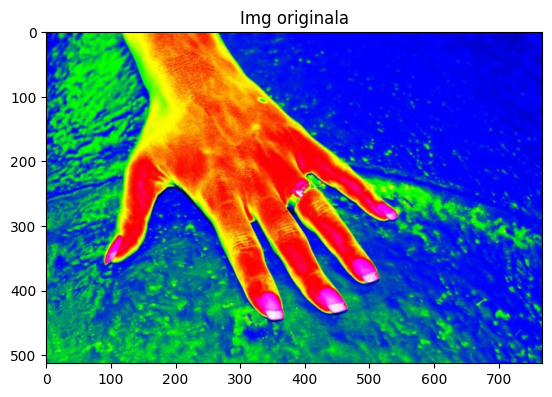

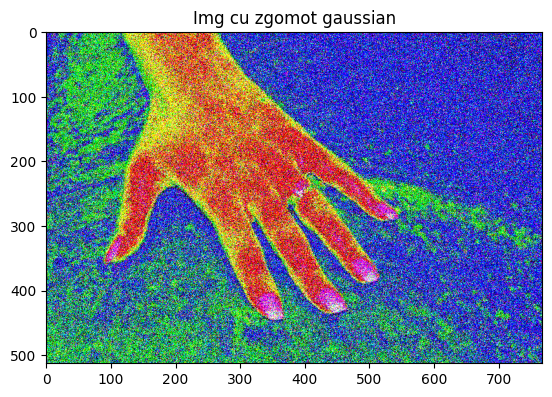

(516, 771, 3)


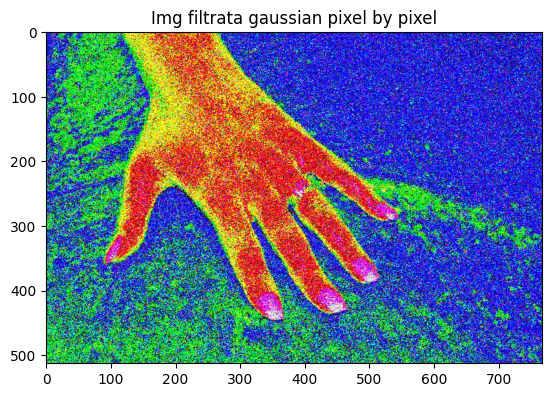

Results:
Gaussian points: 61815
Impulsive points: 123089
Normal points: 997048

Gaussian noise: 5.23%
Impulsive noise: 10.41%
Normal points: 5.23%
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
MSE for gaussian: 0.019168313569748137
NMSE for gaussian: 5.2845612371037996e-08

#
#
#
#
#
#


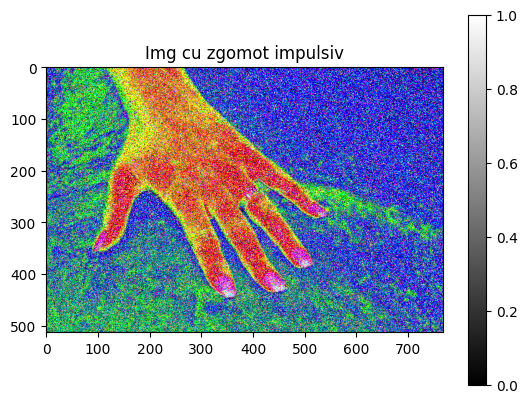

(516, 771, 3)


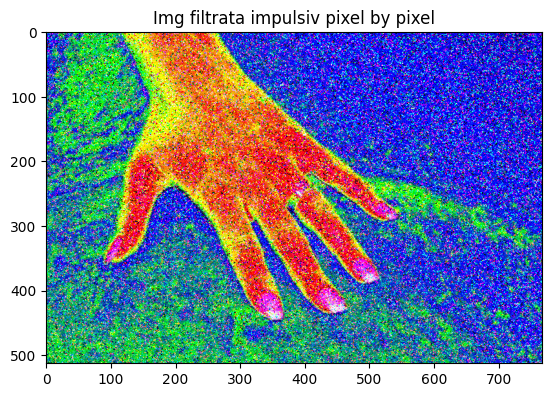

Results:
Gaussian points: 124224
Impulsive points: 133834
Normal points: 923894

Gaussian noise: 10.51%
Impulsive noise: 11.32%
Normal points: 10.51%
MSE for impulsive: 0.03384144133219631
NMSE for impulsive: 8.137670385082204e-08


In [23]:
# Example usage of Self-adaptive Weighted mean and Self-adaptive Weighted median filter
#                  ###### gaussian ######          ##### impulsive ##### 

img = io.imread('infrared-768x513.jpg')
L,C,pl = np.shape(img)

if pl > 3:
    print("original image has also transparency \nsize was {0}".format(np.shape(img)))
    img=img[:,:,:3]
else:
    print(np.shape(img))

# TODO: regleaza pragul T1 (schimba tot ca sa nu mai ai valori intre 0 si 1 in img in functii niciunde)
img=np.uint8(img)
T1, T2 = compute_thresholds(np.uint8(color.rgb2gray(img[:,:,:3])*255))
T1 = T1/255.
print(np.max(img))
print("T1 = {0}, T2 = {1}".format(T1,T2))

plt.figure(), plt.title("Img originala"), plt.imshow(img), plt.show()

# add gaussian noise
img_noise_gauss = add_gaussian_noise(img, 0.5)
plt.figure(), plt.title("Img cu zgomot gaussian"), plt.imshow(img_noise_gauss), plt.show()

# filter with pixel by pixel function
[imgout, gaussian_counter, impulsive_counter, normal_counter] = compute_image_with_noise_color(img_noise_gauss, np.ones((3,3))/9.0, T1, T2)

# see results
plt.figure(), plt.title("Img filtrata gaussian pixel by pixel"), plt.imshow(imgout), plt.show()
print("Results:\nGaussian points: {0}\nImpulsive points: {1}\nNormal points: {2}".format(gaussian_counter, impulsive_counter, normal_counter))
print("\nGaussian noise: {0}%\nImpulsive noise: {1}%".format(round(gaussian_counter/(L*C*3)*100,2), round(impulsive_counter/(L*C*3)*100,2)))
print("Normal points: {0}%".format(round(gaussian_counter/(L*C*3)*100,2)))

# MSE, NMSE
print(type(imgout), type(img_noise_gauss))
MSE_gauss, NMSE_gauss = MSE(imgout, img_noise_gauss)
print("MSE for gaussian: {0}".format(MSE_gauss))
print("NMSE for gaussian: {0}".format(NMSE_gauss))

###########################################################################################
print("\n#\n#\n#\n#\n#\n#")

# add impulsive noise
img_noise_impulsive = add_impulsive_noise(img, 0.25, 0.25)
plt.figure(),plt.title("Img cu zgomot impulsiv") , plt.imshow(img_noise_impulsive, cmap='gray'),plt.colorbar(),plt.show()

# filter with pixel by pixel function
[imgout, gaussian_counter, impulsive_counter, normal_counter] = compute_image_with_noise_color(img_noise_impulsive, np.ones((3,3))/9.0, T1, T2)

# see results
plt.figure(), plt.title("Img filtrata impulsiv pixel by pixel"), plt.imshow(imgout), plt.show()
print("Results:\nGaussian points: {0}\nImpulsive points: {1}\nNormal points: {2}".format(gaussian_counter, impulsive_counter, normal_counter))
print("\nGaussian noise: {0}%\nImpulsive noise: {1}%".format(round(gaussian_counter/(L*C*3)*100,2), round(impulsive_counter/(L*C*3)*100,2)))
print("Normal points: {0}%".format(round(gaussian_counter/(L*C*3)*100,2)))

# MSE, NMSE
MSE_impulsive, NMSE_impulsive = MSE(imgout, img_noise_impulsive)
print("MSE for impulsive: {0}".format(MSE_impulsive))
print("NMSE for impulsive: {0}".format(NMSE_impulsive))